## **Libraries and packages**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

## **Data**

In [2]:
def unpack_results(path_to_file):
    results = np.load(path_to_file, allow_pickle=True)
    datasets = []

    all_columns = set()
    for result in results:
        all_columns.update(result.keys())
    all_columns = list(all_columns)

    for i, result in enumerate(results):
        df = pd.DataFrame(result)
        df = df.reindex(columns=all_columns)
        datasets.append(df)
        
    all_datasets = pd.concat(datasets)
    return all_datasets

In [3]:
rand = unpack_results('../results/random_search_tuning.npy')
bayes = unpack_results('../results/bayes_search_tuning.npy')
default = unpack_results('../results/default_hyperparameter.npy')

## **Results and Visualization**

### **AUC Distribution**

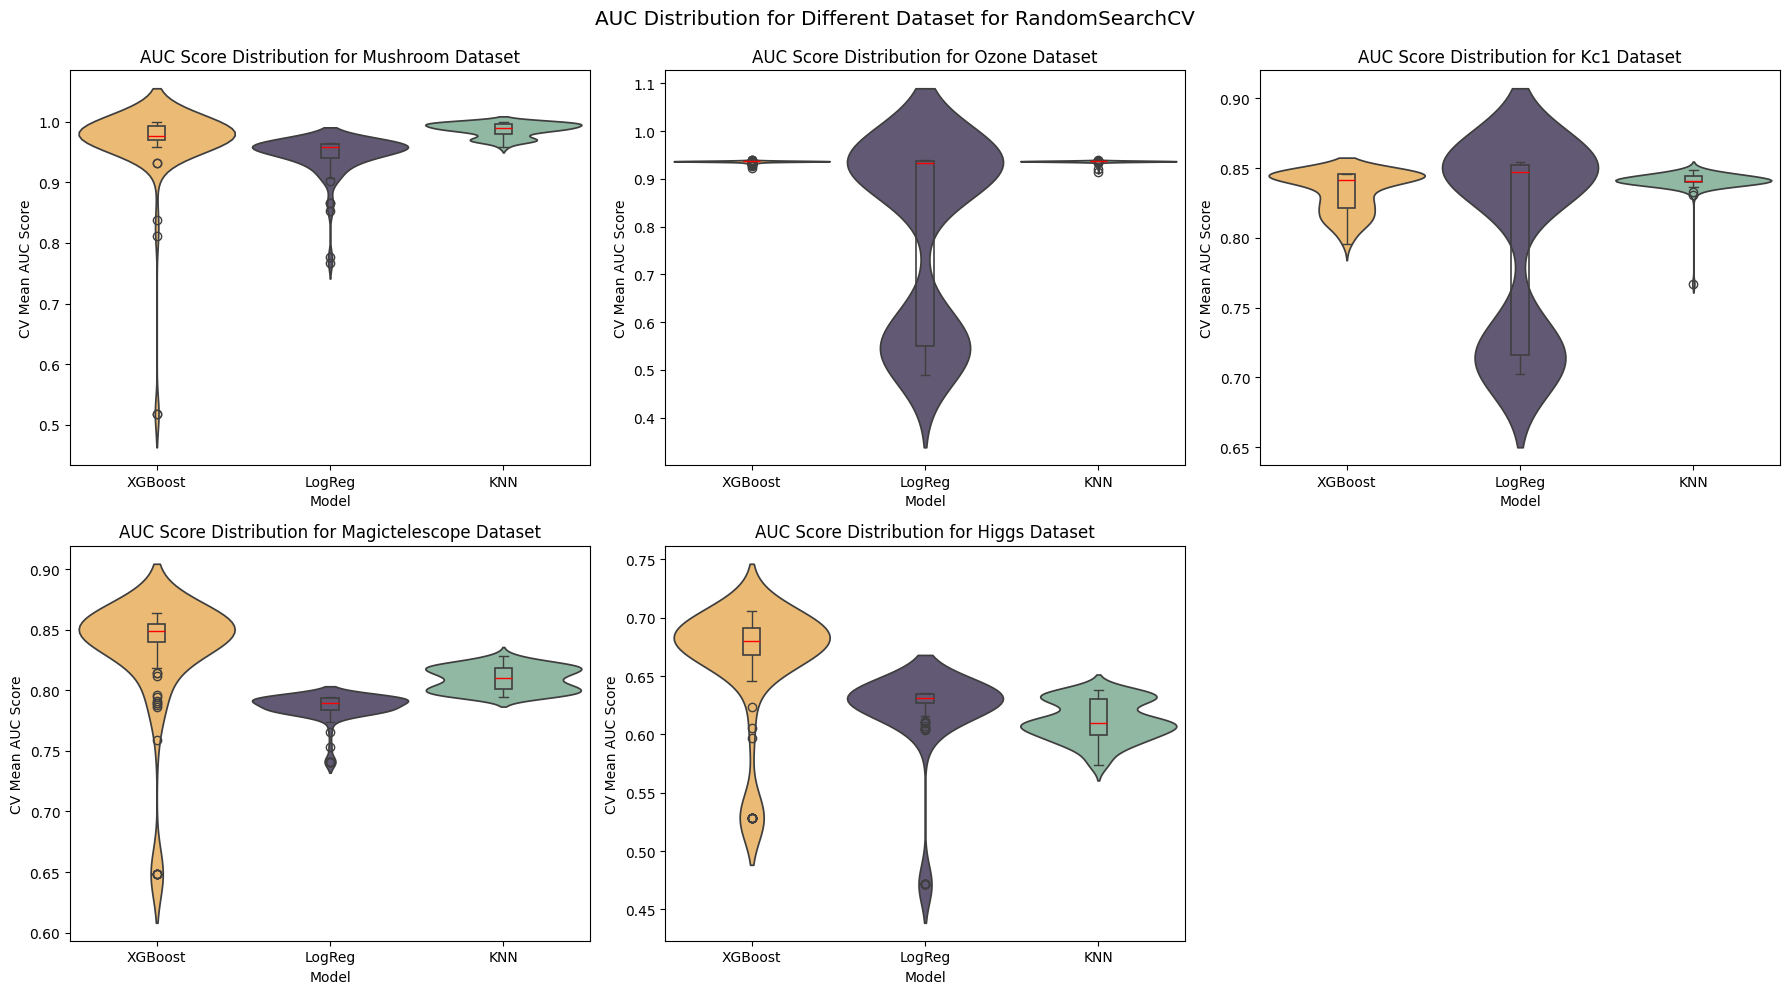

In [4]:
dataset_names = ['mushroom', 'ozone', 'kc1', 'magic', 'higgs']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten() 

for i, dataset_name in enumerate(dataset_names):
    ax = axes[i]
    
    rand_dataset = rand[rand['dataset'] == dataset_name]
    rand_xgb = rand_dataset[rand_dataset['model'] == 'xgb']
    rand_knn = rand_dataset[rand_dataset['model'] == 'knn']
    rand_lr = rand_dataset[rand_dataset['model'] == 'logreg']

    data = pd.DataFrame({
        'XGBoost': rand_xgb['mean_test_score'].values,
        'LogReg': rand_lr['mean_test_score'].values,
        'KNN': rand_knn['mean_test_score'].values
    })

    data_melted = data.melt(var_name='Model', value_name='Mean AUC Score')

    colors = {'XGBoost': '#FFBF61', 'LogReg': '#605678','KNN': '#8ABFA3'}

    sns.violinplot(x='Model', y='Mean AUC Score', data=data_melted, ax=ax, inner=None, width=0.9, hue='Model', palette=colors)
    
    sns.boxplot(x='Model', y='Mean AUC Score', data=data_melted, whis=1.5, width=0.1, ax=ax, 
                boxprops={'facecolor':'none', 'linewidth':1.2}, medianprops={'color':'red'})
    if dataset_name == 'magic':
        dataset_name = 'magicTelescope'
    ax.set_title(f'AUC Score Distribution for {dataset_name.capitalize()} Dataset')
    ax.set_xlabel('Model')
    ax.set_ylabel('CV Mean AUC Score', fontsize=10)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
fig.suptitle('AUC Distribution for Different Dataset for RandomSearchCV', fontsize='x-large', y=0.99)
plt.tight_layout()
plt.savefig('../plots/auc-distribution-violinplot.png', transparent=True)
plt.show()


In [5]:
def boxplot_all_datasets(rand):
    rand_xgb = rand[rand['model'] == 'xgb']
    rand_knn = rand[rand['model'] == 'knn']
    rand_lr = rand[rand['model'] == 'logreg']


    data = pd.DataFrame({
        'XGBoost': rand_xgb['mean_test_score'].values,
        'LogReg': rand_lr['mean_test_score'].values,
        'KNN': rand_knn['mean_test_score'].values
    })

    data_melted = data.melt(var_name='Model', value_name='Mean AUC Score')

    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Model', y='Mean AUC Score', data=data_melted, color='#FFBF61')
    plt.title('AUC Distribution for all Datasets')
    plt.xlabel('Model')
    plt.ylabel('Tuned Hyperparameters AUC', fontsize=8)
    plt.show()

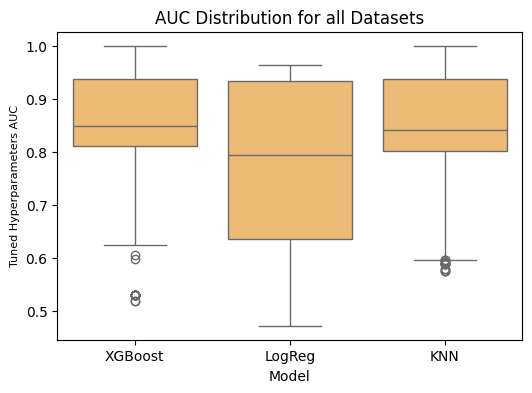

In [6]:
boxplot_all_datasets(rand)

### **Tunability**

In [7]:
tunability_data = []

for dataset_name in dataset_names:
    rand_dataset = rand[rand['dataset'] == dataset_name]
    default_dataset = default[default['dataset'] == dataset_name]

    xgb_diff = round(-float(np.max(rand_dataset[rand_dataset['model'] == 'xgb']['mean_test_score'].values) - 
                     np.mean(default_dataset[default_dataset['model'] == 'xgb']['train_score'].values)), 4)
    logreg_diff = round(-float(np.max(rand_dataset[rand_dataset['model'] == 'logreg']['mean_test_score'].values) - 
                        np.mean(default_dataset[default_dataset['model'] == 'logreg']['train_score'].values)), 4)
    knn_diff = round(-float(np.max(rand_dataset[rand_dataset['model'] == 'knn']['mean_test_score'].values) - 
                     np.mean(default_dataset[default_dataset['model'] == 'knn']['train_score'].values)), 4)
    if dataset_name == 'magic':
        dataset_name = 'magicTelescope'
    tunability_data.append({
        'Dataset': dataset_name,
        'XGBoost': xgb_diff,
        'LogReg': logreg_diff,
        'KNN': knn_diff
    })

tunability_df = pd.DataFrame(tunability_data)

print(tabulate(tunability_df, headers='keys', tablefmt='simple', showindex=False))


Dataset           XGBoost    LogReg      KNN
--------------  ---------  --------  -------
mushroom          -0        -0.002   -0.0001
ozone              0.0596    0.0099   0.0174
kc1                0.1401    0.008    0.0177
magicTelescope     0.1351    0.0003   0.0395
higgs              0.2942    0.0091   0.096


### **Bayes Search Convergence**

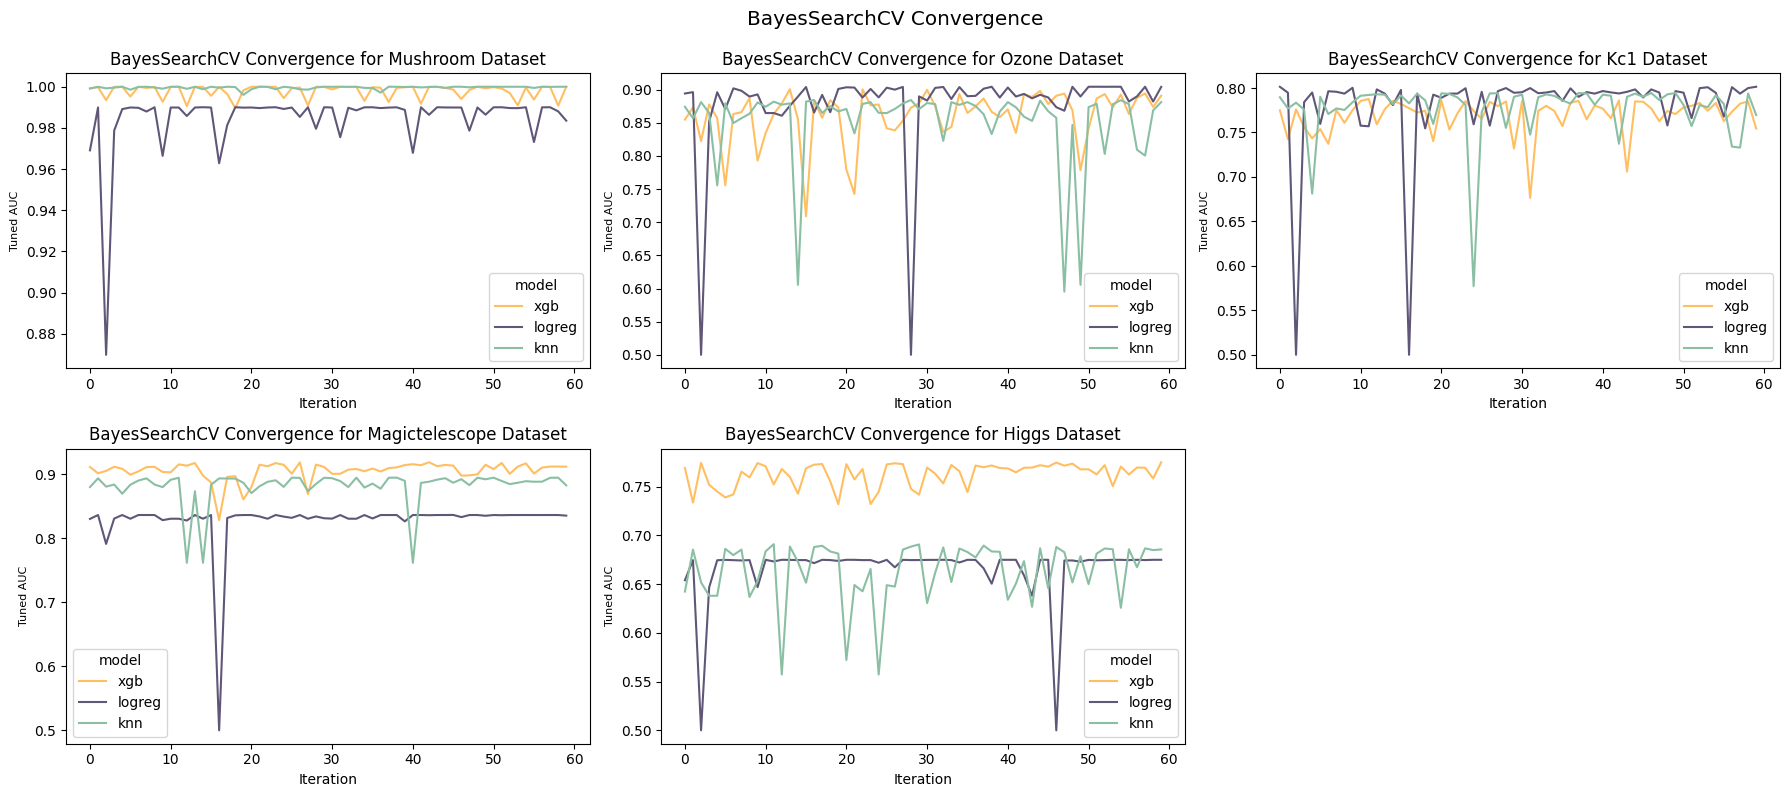

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten() 

for i, dataset_name in enumerate(dataset_names):
    ax = axes[i]
    
    bayes_dataset = bayes[bayes['dataset'] == dataset_name].copy()
    bayes_dataset.loc[:, 'iter'] = bayes_dataset.index

    if dataset_name == 'magic':
        dataset_name = 'magicTelescope'

    colors = ['#FFBF61', '#605678', '#8ABFA3']
    sns.lineplot(x='iter', y='mean_test_score', hue='model', data=bayes_dataset, ax=ax, palette=colors)
    ax.set_title(f'BayesSearchCV Convergence for {dataset_name.capitalize()} Dataset')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Tuned AUC', fontsize=8)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('BayesSearchCV Convergence', fontsize='x-large', y=0.99)
plt.tight_layout()
fig.savefig('../plots/bayes-convergence.png', transparent=True)
plt.show()

In [9]:
def cummulative_max_plots(dataset_names, method):
    # method = bayes / rand
    if method == 'bayes':
        method_name = 'BayesSearchCV'
        res = bayes
    elif method == 'random':
        method_name = 'RandomSearchCV'
        res = rand

    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    axes = axes.flatten()

    for i, dataset_name in enumerate(dataset_names):
        ax = axes[i]
        
        results = res[res['dataset'] == dataset_name].copy()
        results['iter'] = results.index  

        results['cumulative_max_score'] = results.groupby('model')['mean_test_score'].cummax()
        
        if dataset_name == 'magic':
            dataset_name = 'magicTelescope'
        
        colors = ['#FFBF61', '#605678', '#8ABFA3']
        sns.lineplot(x='iter', y='cumulative_max_score', hue='model', data=results, ax=ax, palette=colors)
        ax.set_title(f'{method_name} Convergence for {dataset_name.capitalize()} Dataset')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Cumulative Max AUC', fontsize=8)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f'{method_name} Convergence (Commulative Max)', fontsize='x-large', y=0.99)
    plt.tight_layout()
    plt.savefig(f'../plots/{method}-cummax.png', transparent=True)
    plt.show()


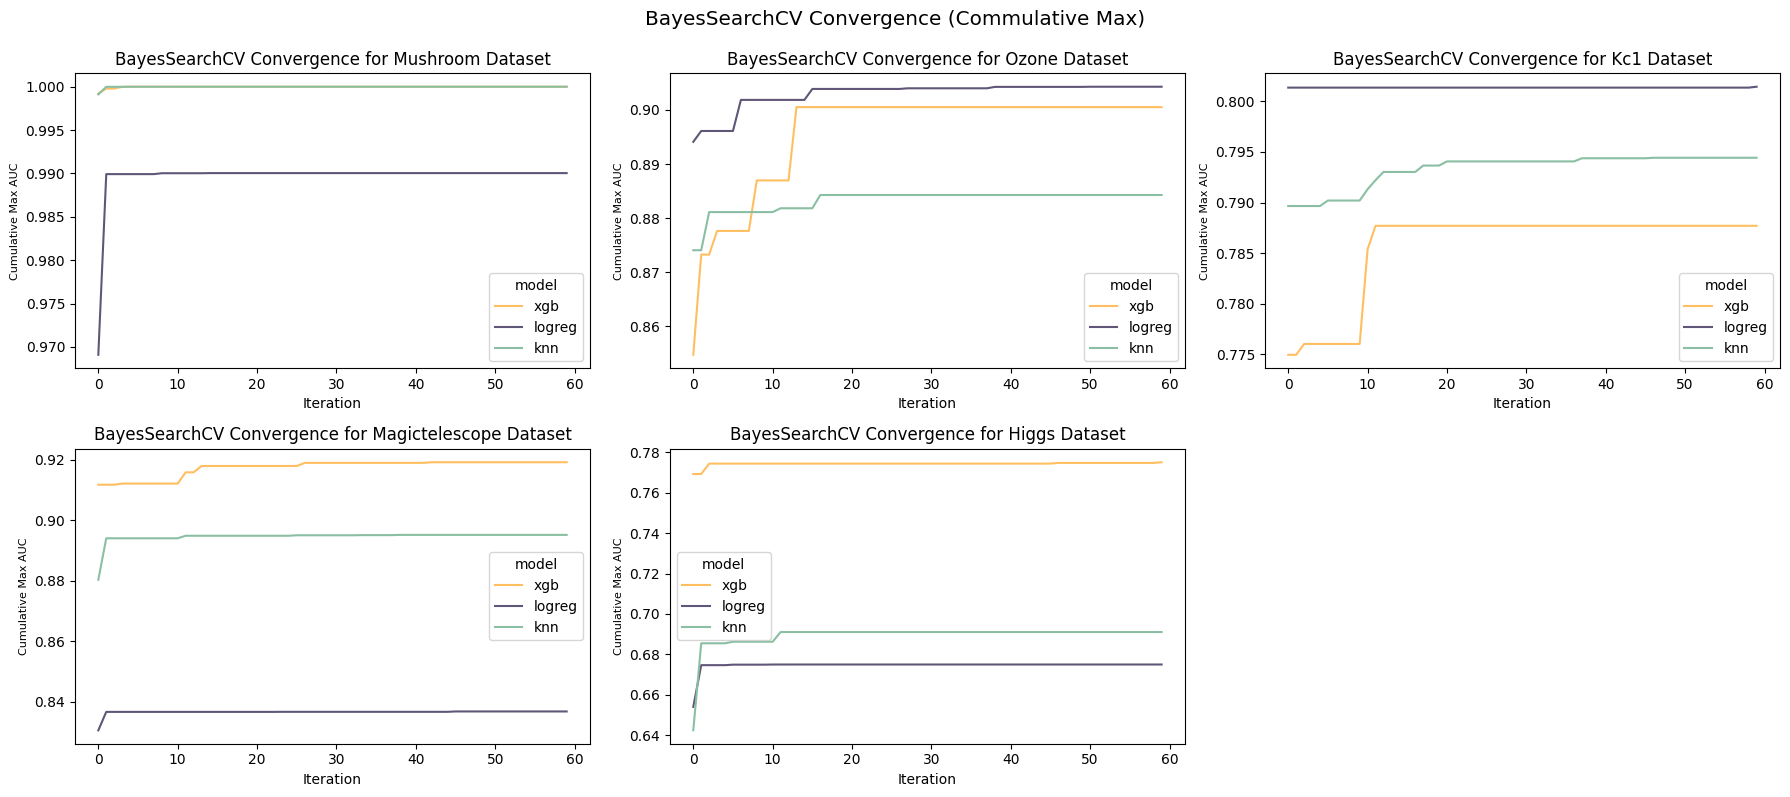

In [10]:
cummulative_max_plots(dataset_names, 'bayes')

### **Random Search Convergence**

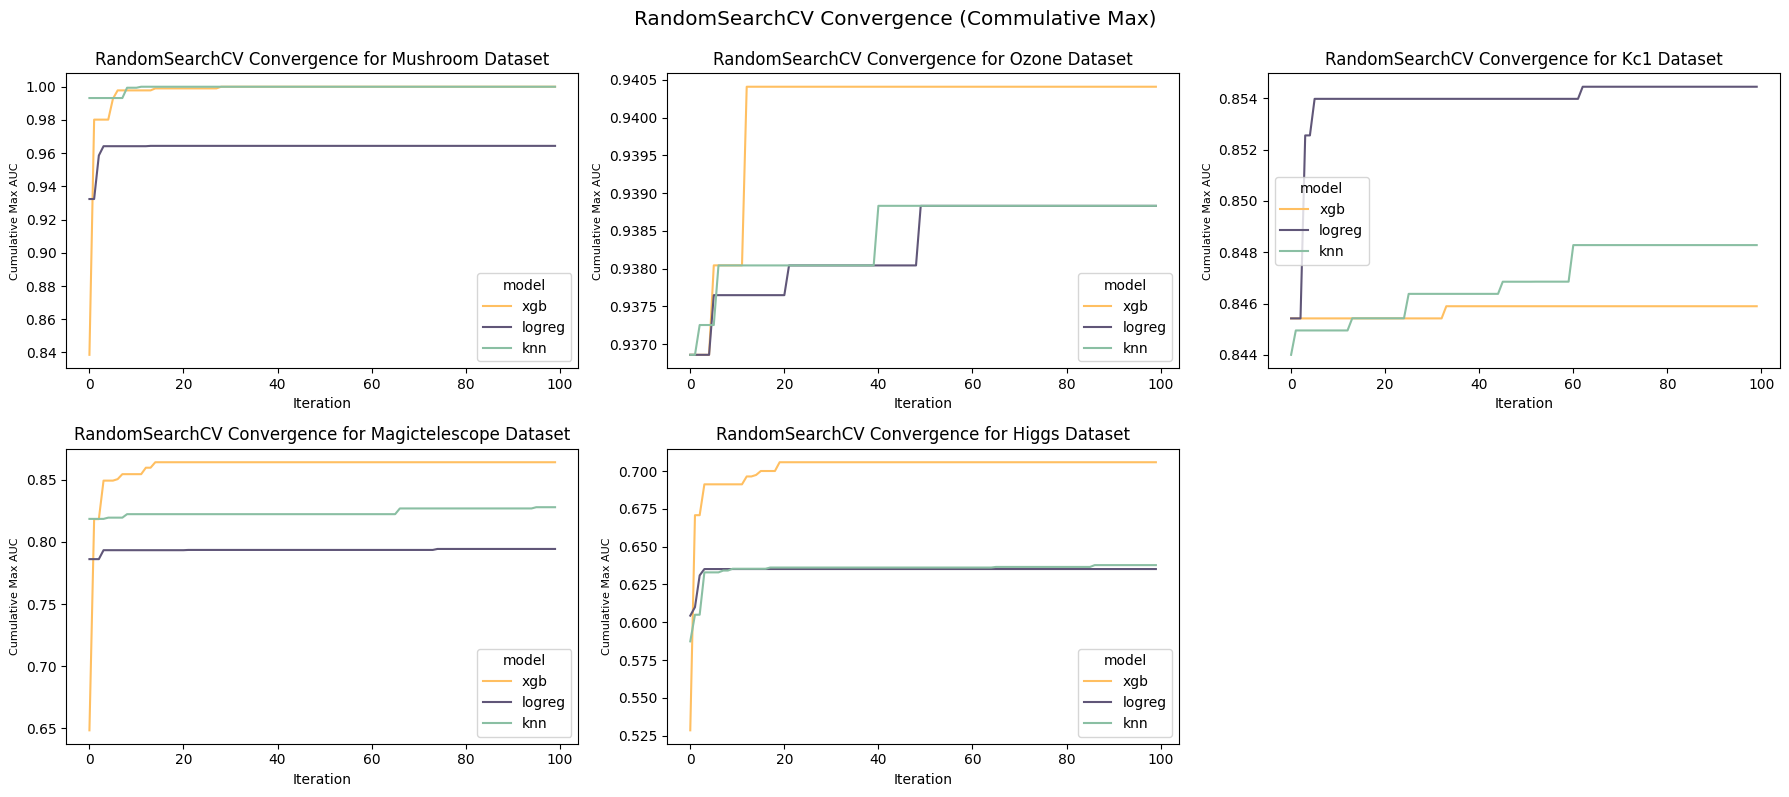

In [11]:
cummulative_max_plots(dataset_names, 'random')

### **Best Hyperparameters**

In [12]:
import ast

xgb_cols = ['param_xgb__min_child_weight', 'param_xgb__reg_alpha', 'param_xgb__reg_lambda', 'param_xgb__learning_rate', 'param_xgb__n_estimators']
knn_cols = ['param_knn__n_neighbors', 'param_knn__weights', 'param_knn__metric']
logreg_cols = ['param_logreg__C', 'param_logreg__max_iter', 'param_logreg__penalty', 'param_logreg__solver']

def find_best_hyperparams(model, cols):
    x = rand[rand['model'] == model]
    x.loc[:, 'params'] = x[cols].apply(lambda row: str(row.to_dict()), axis=1)
    mean_scores = x.groupby('params')['mean_test_score'].mean().reset_index()
    best_params_str = mean_scores.sort_values('mean_test_score', ascending=False).head(1)['params'].values[0]
    score = mean_scores.sort_values('mean_test_score', ascending=False).head(1)['mean_test_score'].values[0]
    
    best_params = ast.literal_eval(best_params_str)
    print(f'Score: {score:.4f}')
    print(f'Best hyperparameters for {model.upper()}:')
    for key, value in best_params.items():
        if isinstance(value, float):
            value = round(value, 2)
        print(f'{key}: {value}')


In [13]:
find_best_hyperparams('xgb', xgb_cols)

Score: 0.8646
Best hyperparameters for XGB:
param_xgb__min_child_weight: 15.0
param_xgb__reg_alpha: 8.85
param_xgb__reg_lambda: 18.72
param_xgb__learning_rate: 0.49
param_xgb__n_estimators: 480.0


In [14]:
find_best_hyperparams('knn', knn_cols)

Score: 0.8468
Best hyperparameters for KNN:
param_knn__n_neighbors: 27.0
param_knn__weights: distance
param_knn__metric: manhattan


In [15]:
find_best_hyperparams('logreg', logreg_cols)

Score: 0.8362
Best hyperparameters for LOGREG:
param_logreg__C: 1.16
param_logreg__max_iter: 7535.0
param_logreg__penalty: l1
param_logreg__solver: liblinear


### **Default results**

In [16]:
default

,model,fit_time,test_score,score_time,train_score,dataset
0,xgb,0.041043,1.000,0.015795,1.00000,mushroom
1,xgb,0.042413,1.000,0.014467,1.00000,mushroom
2,xgb,0.039609,1.000,0.015695,1.00000,mushroom
3,xgb,0.042013,1.000,0.015433,1.00000,mushroom
4,xgb,0.045921,1.000,0.014781,1.00000,mushroom
...,...,...,...,...,...,...
0,knn,0.028922,0.579,0.033548,0.73075,higgs
1,knn,0.028721,0.591,0.043415,0.72700,higgs
2,knn,0.015618,0.554,0.033175,0.74000,higgs
3,knn,0.027625,0.593,0.031527,0.73750,higgs


In [17]:
mean_scores = pd.DataFrame(default.groupby('model')['test_score'].mean().round(4))
print(tabulate(mean_scores, headers='keys', tablefmt='simple'))

model      test_score
-------  ------------
knn            0.8296
logreg         0.835
xgb            0.8563


### **Bias sampling**

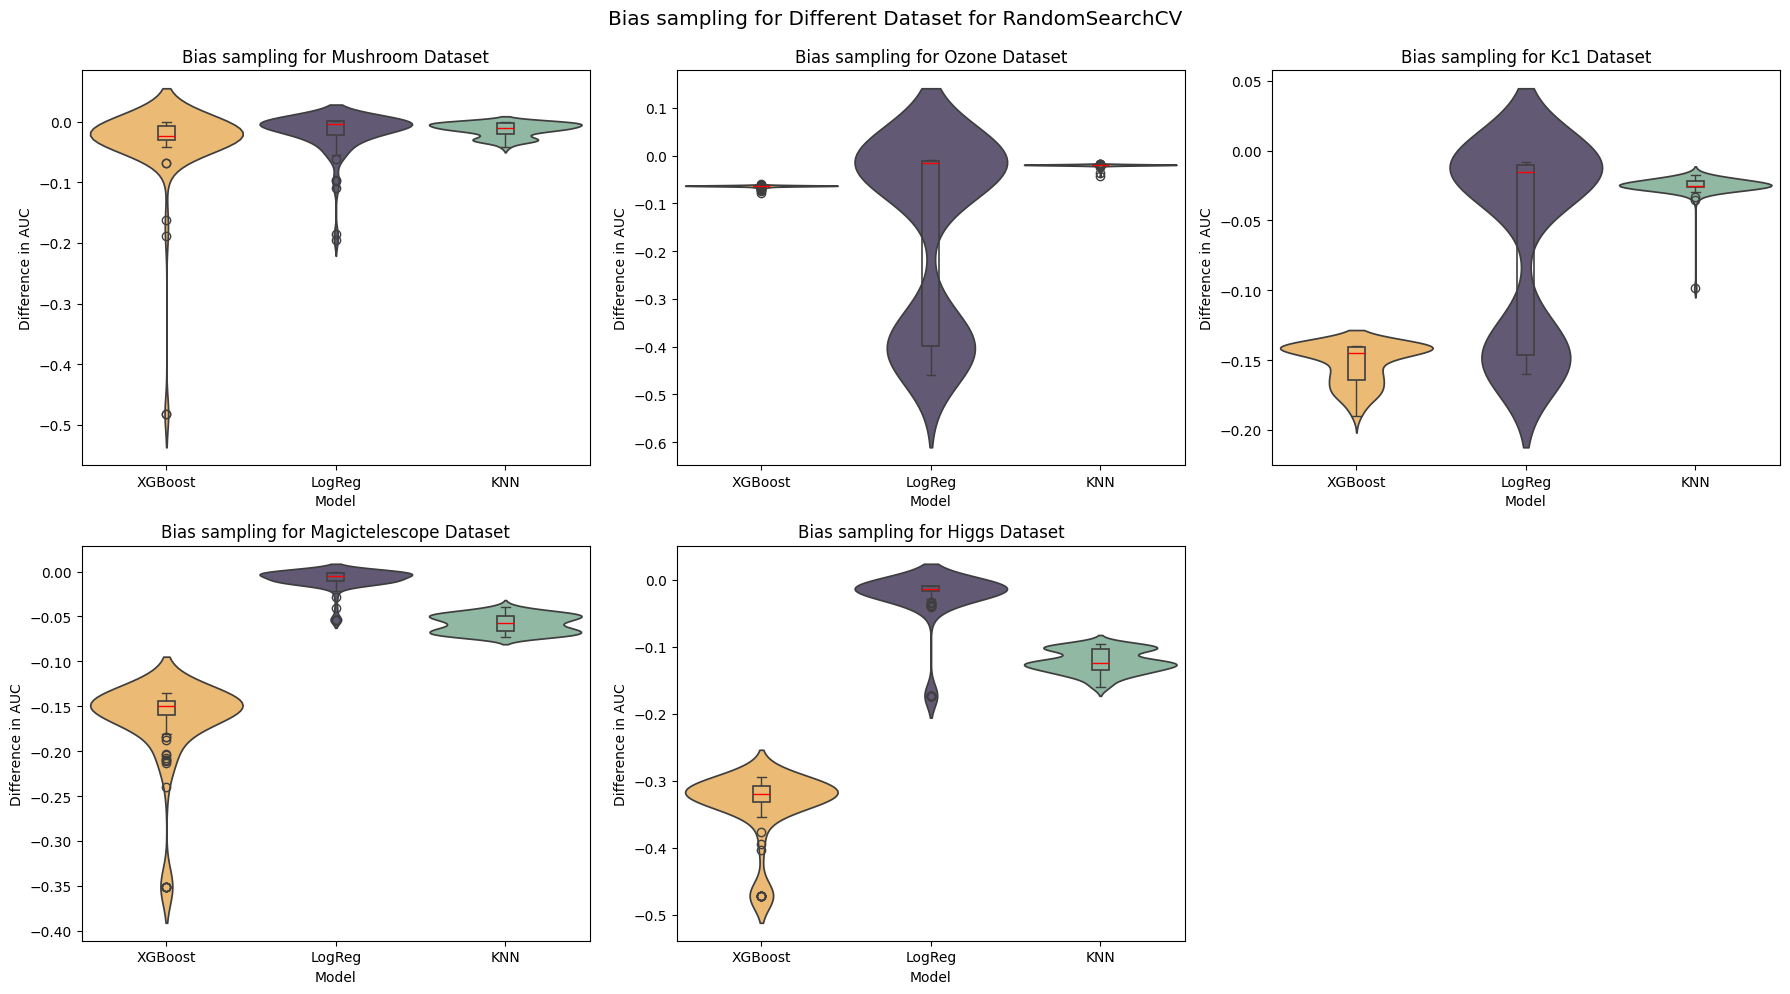

In [18]:
def plot_bias_sampling(method, dataset_names, rand, bayes, default):
    if method == 'random':
        dataset = rand
        method_name = 'RandomSearchCV'
    elif method == 'bayes':
        dataset = bayes
        method_name = 'BayesSearchCV'

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten() 

    for i, dataset_name in enumerate(dataset_names):
        ax = axes[i]
        
        method_dataset = dataset[dataset['dataset'] == dataset_name]
        method_xgb = method_dataset[method_dataset['model'] == 'xgb']
        method_knn = method_dataset[method_dataset['model'] == 'knn']
        method_lr = method_dataset[method_dataset['model'] == 'logreg']

        default_dataset = default[default['dataset'] == dataset_name]
        default_xgb = default_dataset[default_dataset['model'] == 'xgb']
        default_knn = default_dataset[default_dataset['model'] == 'knn']
        default_lr = default_dataset[default_dataset['model'] == 'logreg']

        data = pd.DataFrame({
            'XGBoost': method_xgb['mean_test_score'].values - np.mean(default_xgb['train_score'].values),
            'LogReg': method_lr['mean_test_score'].values - np.mean(default_lr['train_score'].values),
            'KNN': method_knn['mean_test_score'].values - np.mean(default_knn['train_score'].values)
        })

        data_melted = data.melt(var_name='Model', value_name='Difference in AUC')

        colors = {'XGBoost': '#FFBF61', 'LogReg': '#605678', 'KNN': '#8ABFA3'}

        sns.violinplot(x='Model', y='Difference in AUC', data=data_melted, ax=ax, inner=None, width=0.9, hue='Model', palette=colors)
        
        sns.boxplot(x='Model', y='Difference in AUC', data=data_melted, whis=1.5, width=0.1, ax=ax, 
                   boxprops={'facecolor':'none', 'linewidth':1.2}, medianprops={'color':'red'})
        if dataset_name == 'magic':
            dataset_name = 'magicTelescope'
        ax.set_title(f'Bias sampling for {dataset_name.capitalize()} Dataset')
        ax.set_xlabel('Model')
        ax.set_ylabel('Difference in AUC', fontsize=10)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    fig.suptitle(f'Bias sampling for Different Dataset for {method_name}', fontsize='x-large', y=0.99)
    plt.tight_layout()
    plt.savefig(f'../plots/bias-sampling-{method}.png', transparent=True)
    plt.show()

plot_bias_sampling('random', dataset_names, rand, bayes, default)

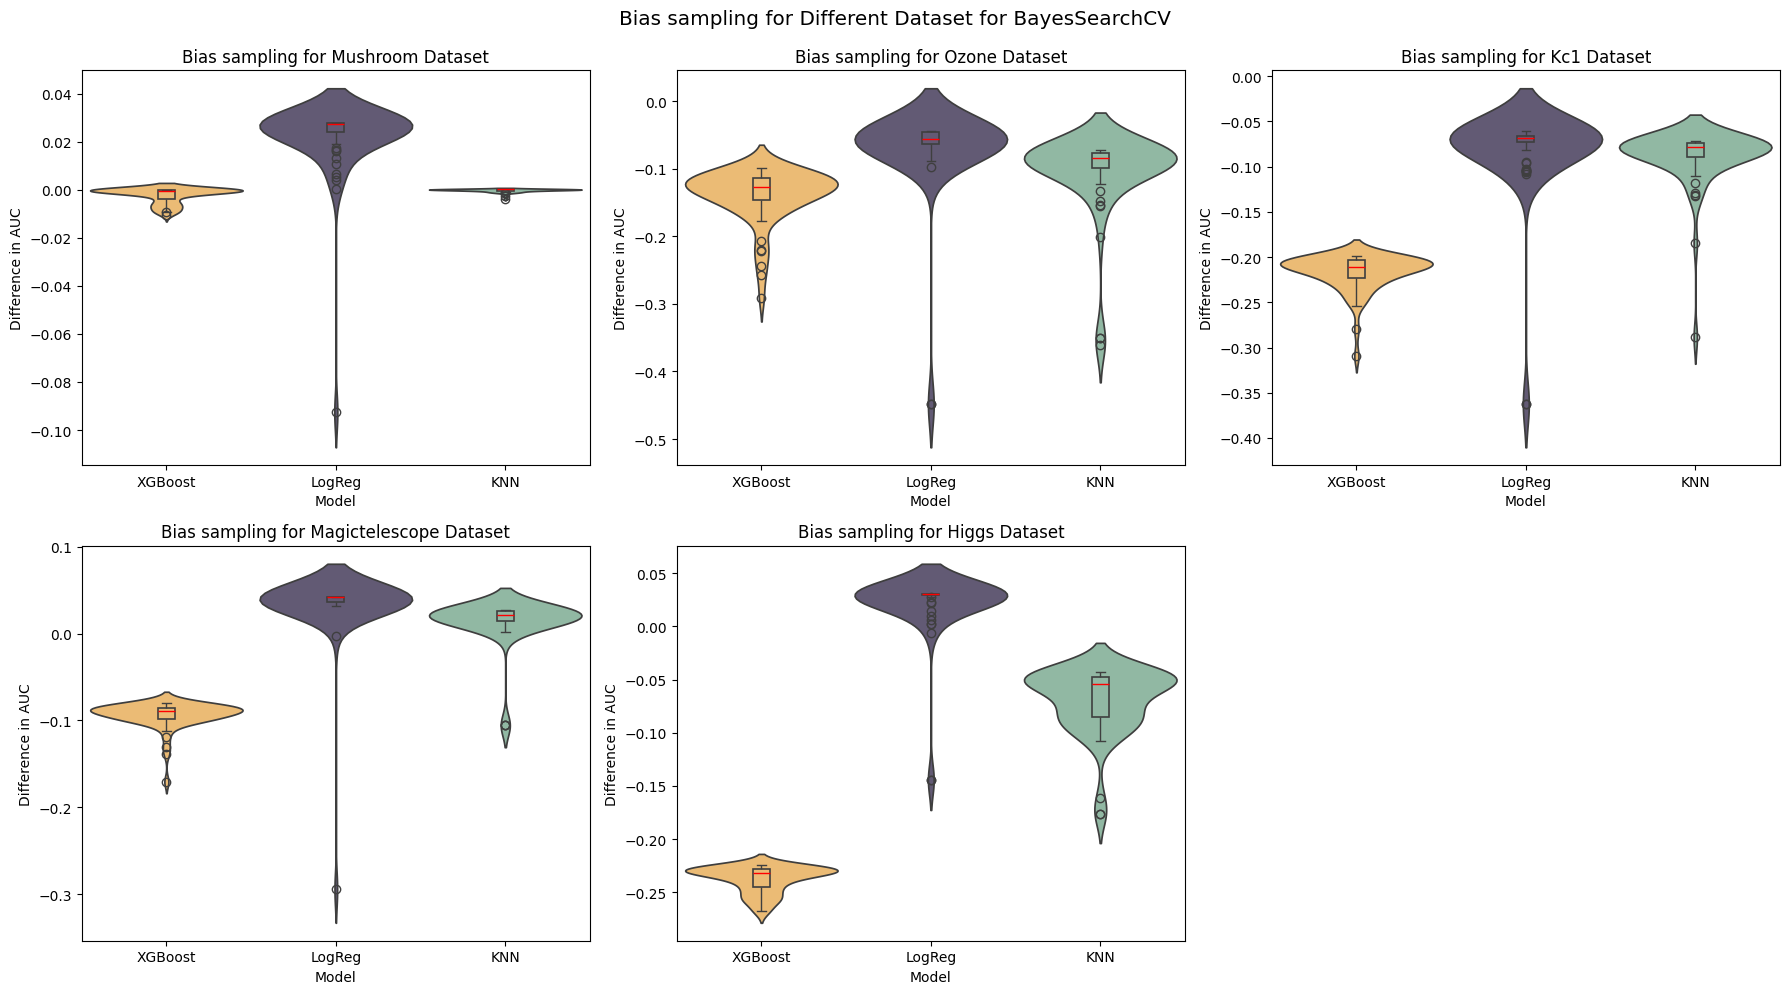

In [19]:
plot_bias_sampling('bayes', dataset_names, rand, bayes, default)

In [20]:
MODELS = ('xgb', 'logreg', 'knn')
METHODS = ('random', 'bayes', 'default')
DATASETS = ('higgs', 'kc1', 'magic', 'mushroom', 'ozone')

In [21]:
def prepare_bias_sampling_results(dataset_name, model_name):
    model_name = 'knn'
    dataset_name = 'kc1'

    df = rand[rand['model']== model_name]
    df_ = df[df['dataset'] == dataset_name]
    rs_mean_test_scores = df_['mean_test_score'].values

    default_ = default[default['model'] == model_name]
    default_score = default_[default_['dataset'] == dataset_name].groupby('dataset').mean('test_score')['test_score'].values[0]
    default_score_list = np.full((100,), default_score)
    result = (rs_mean_test_scores[:100] - default_score_list).reshape(100, 1)

    return result

In [22]:
def bias_sampling_plots(dataset_names, model_name, color):
    fig, axes = plt.subplots(5, 1, figsize=(18, 20))
    axes = axes.flatten()

    for i, dataset_name in enumerate(dataset_names):
        ax = axes[i]
        
        results = prepare_bias_sampling_results(dataset_name, model_name)
        if dataset_name == 'magic':
            dataset_name = 'magicTelescope'
        
        sns.scatterplot(x=range(len(results)), y=results.flatten(), color=color, ax=ax)
        ax.set_title(f'Bias Sampling for {dataset_name.capitalize()} Dataset')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Difference in AUC', fontsize=8)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle('Bias Sampling Results', fontsize='x-large', y=0.99)
    plt.tight_layout()
    plt.savefig(f'../plots/bias-sampling-{model_name}.png', transparent=True)
    plt.show()


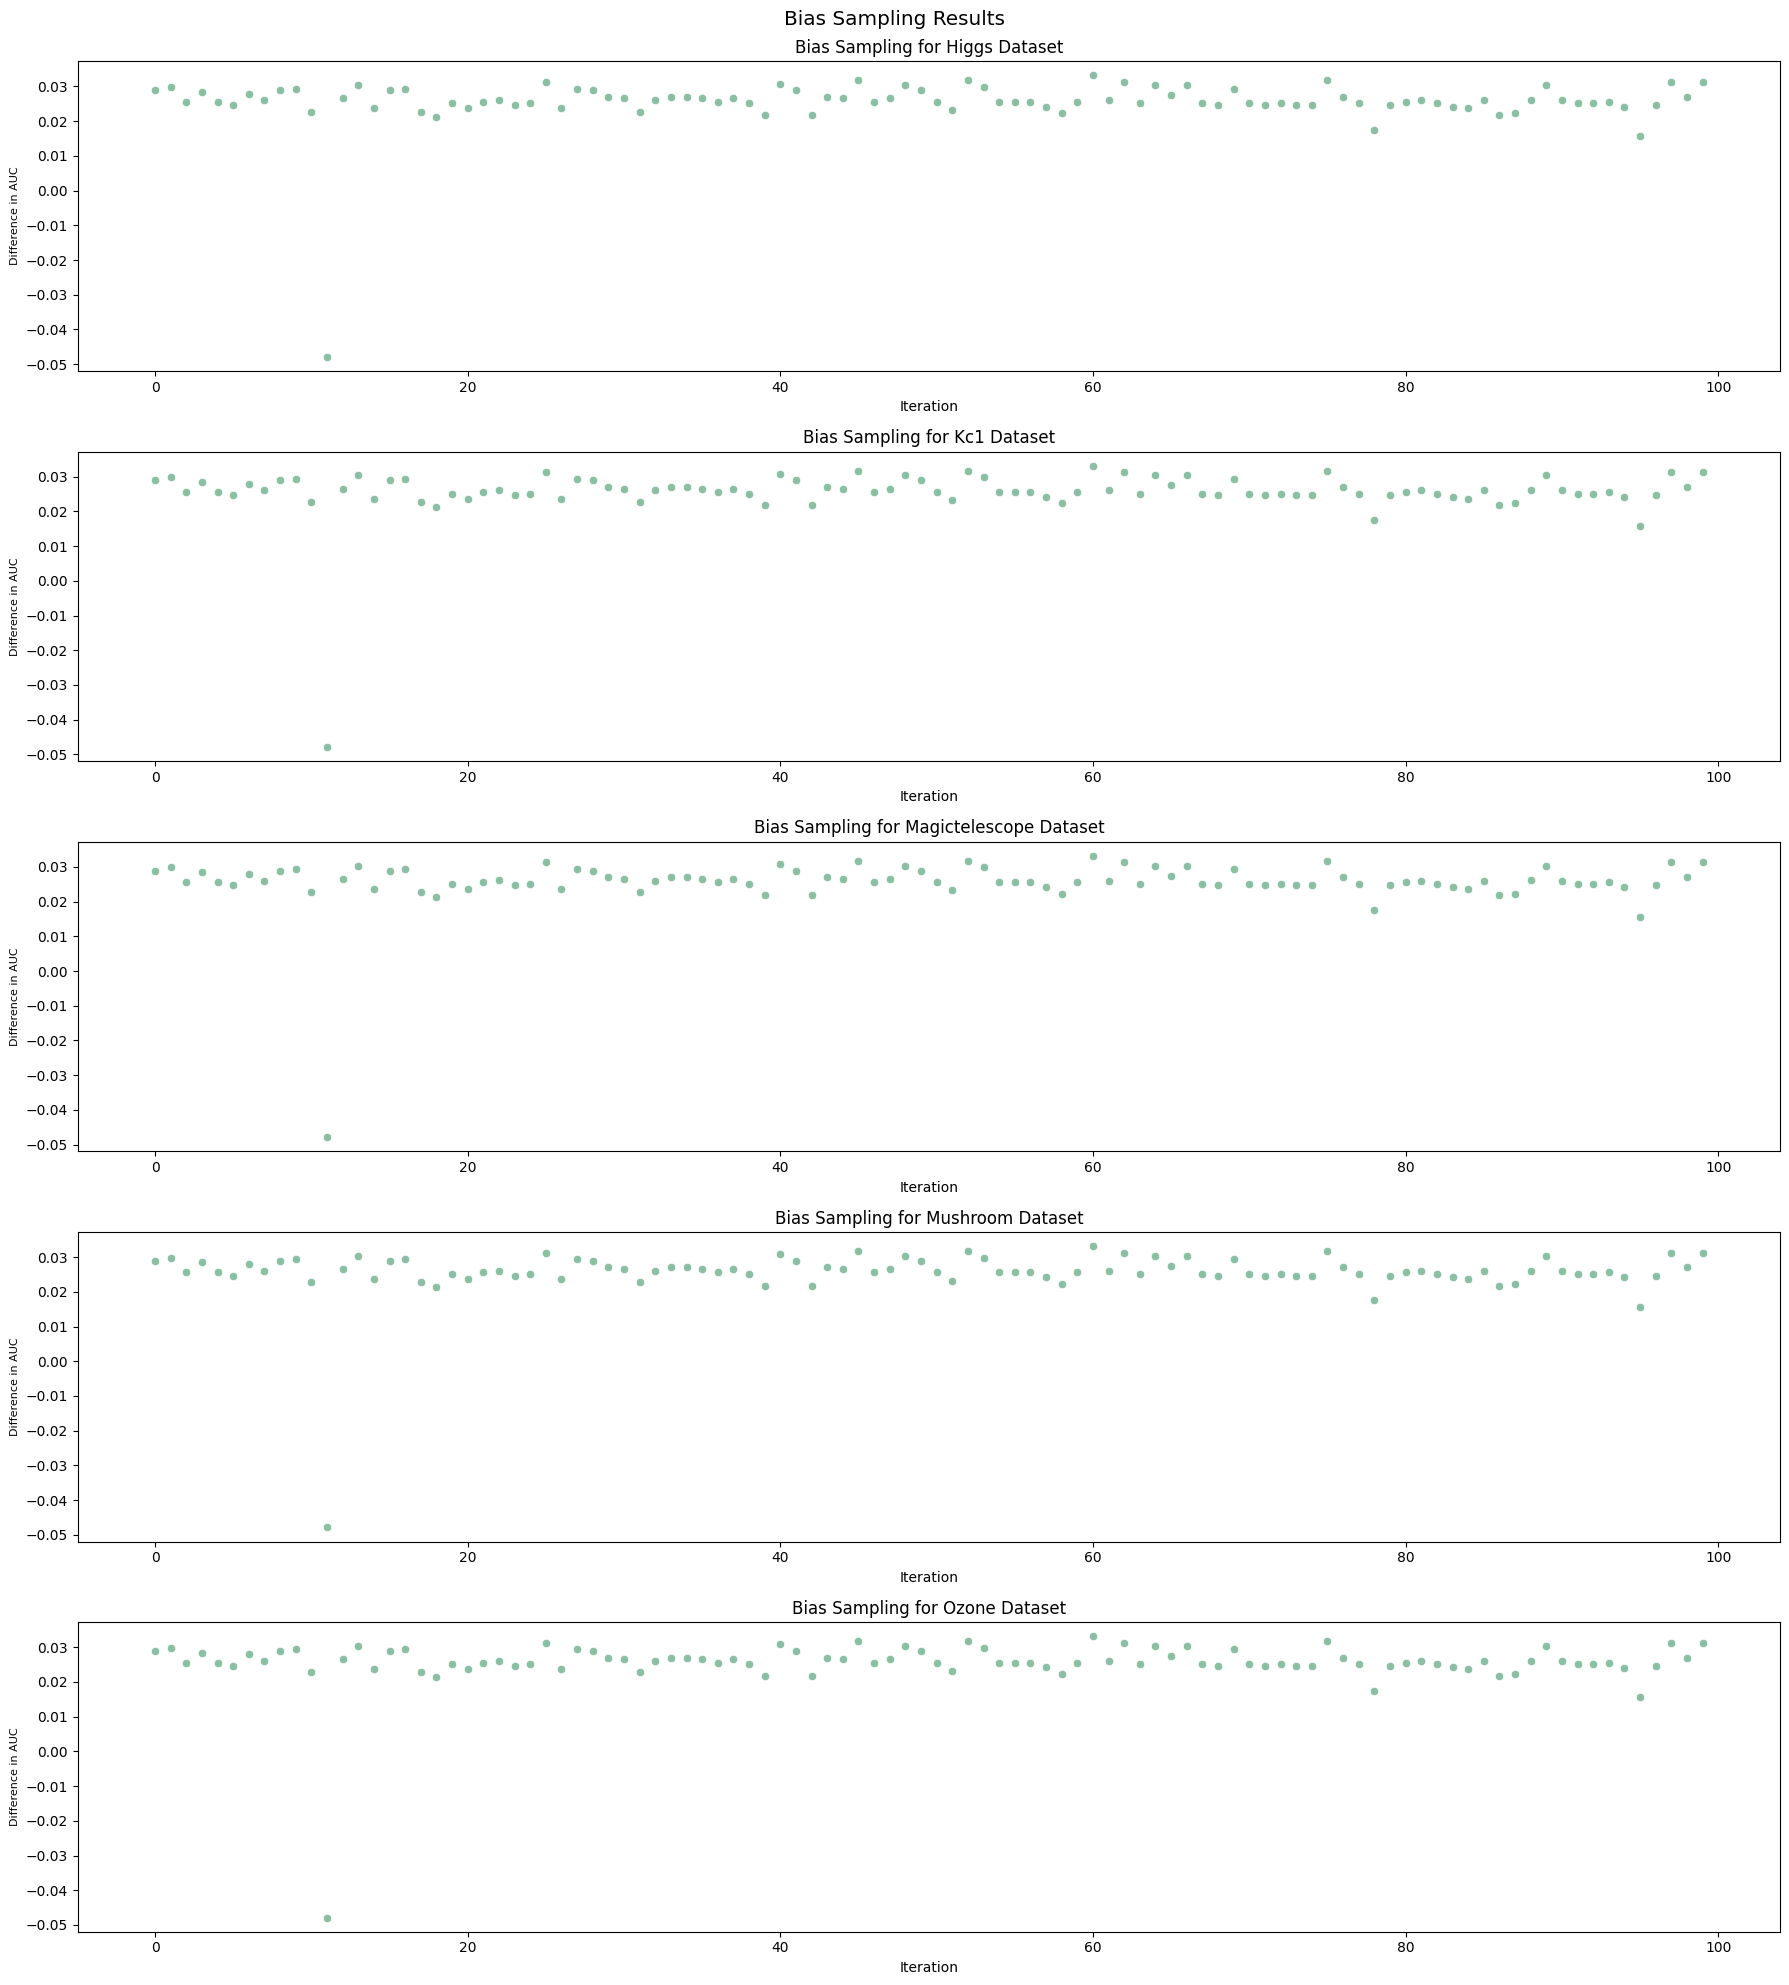

In [23]:
bias_sampling_plots(DATASETS, 'knn', '#8ABFA3')

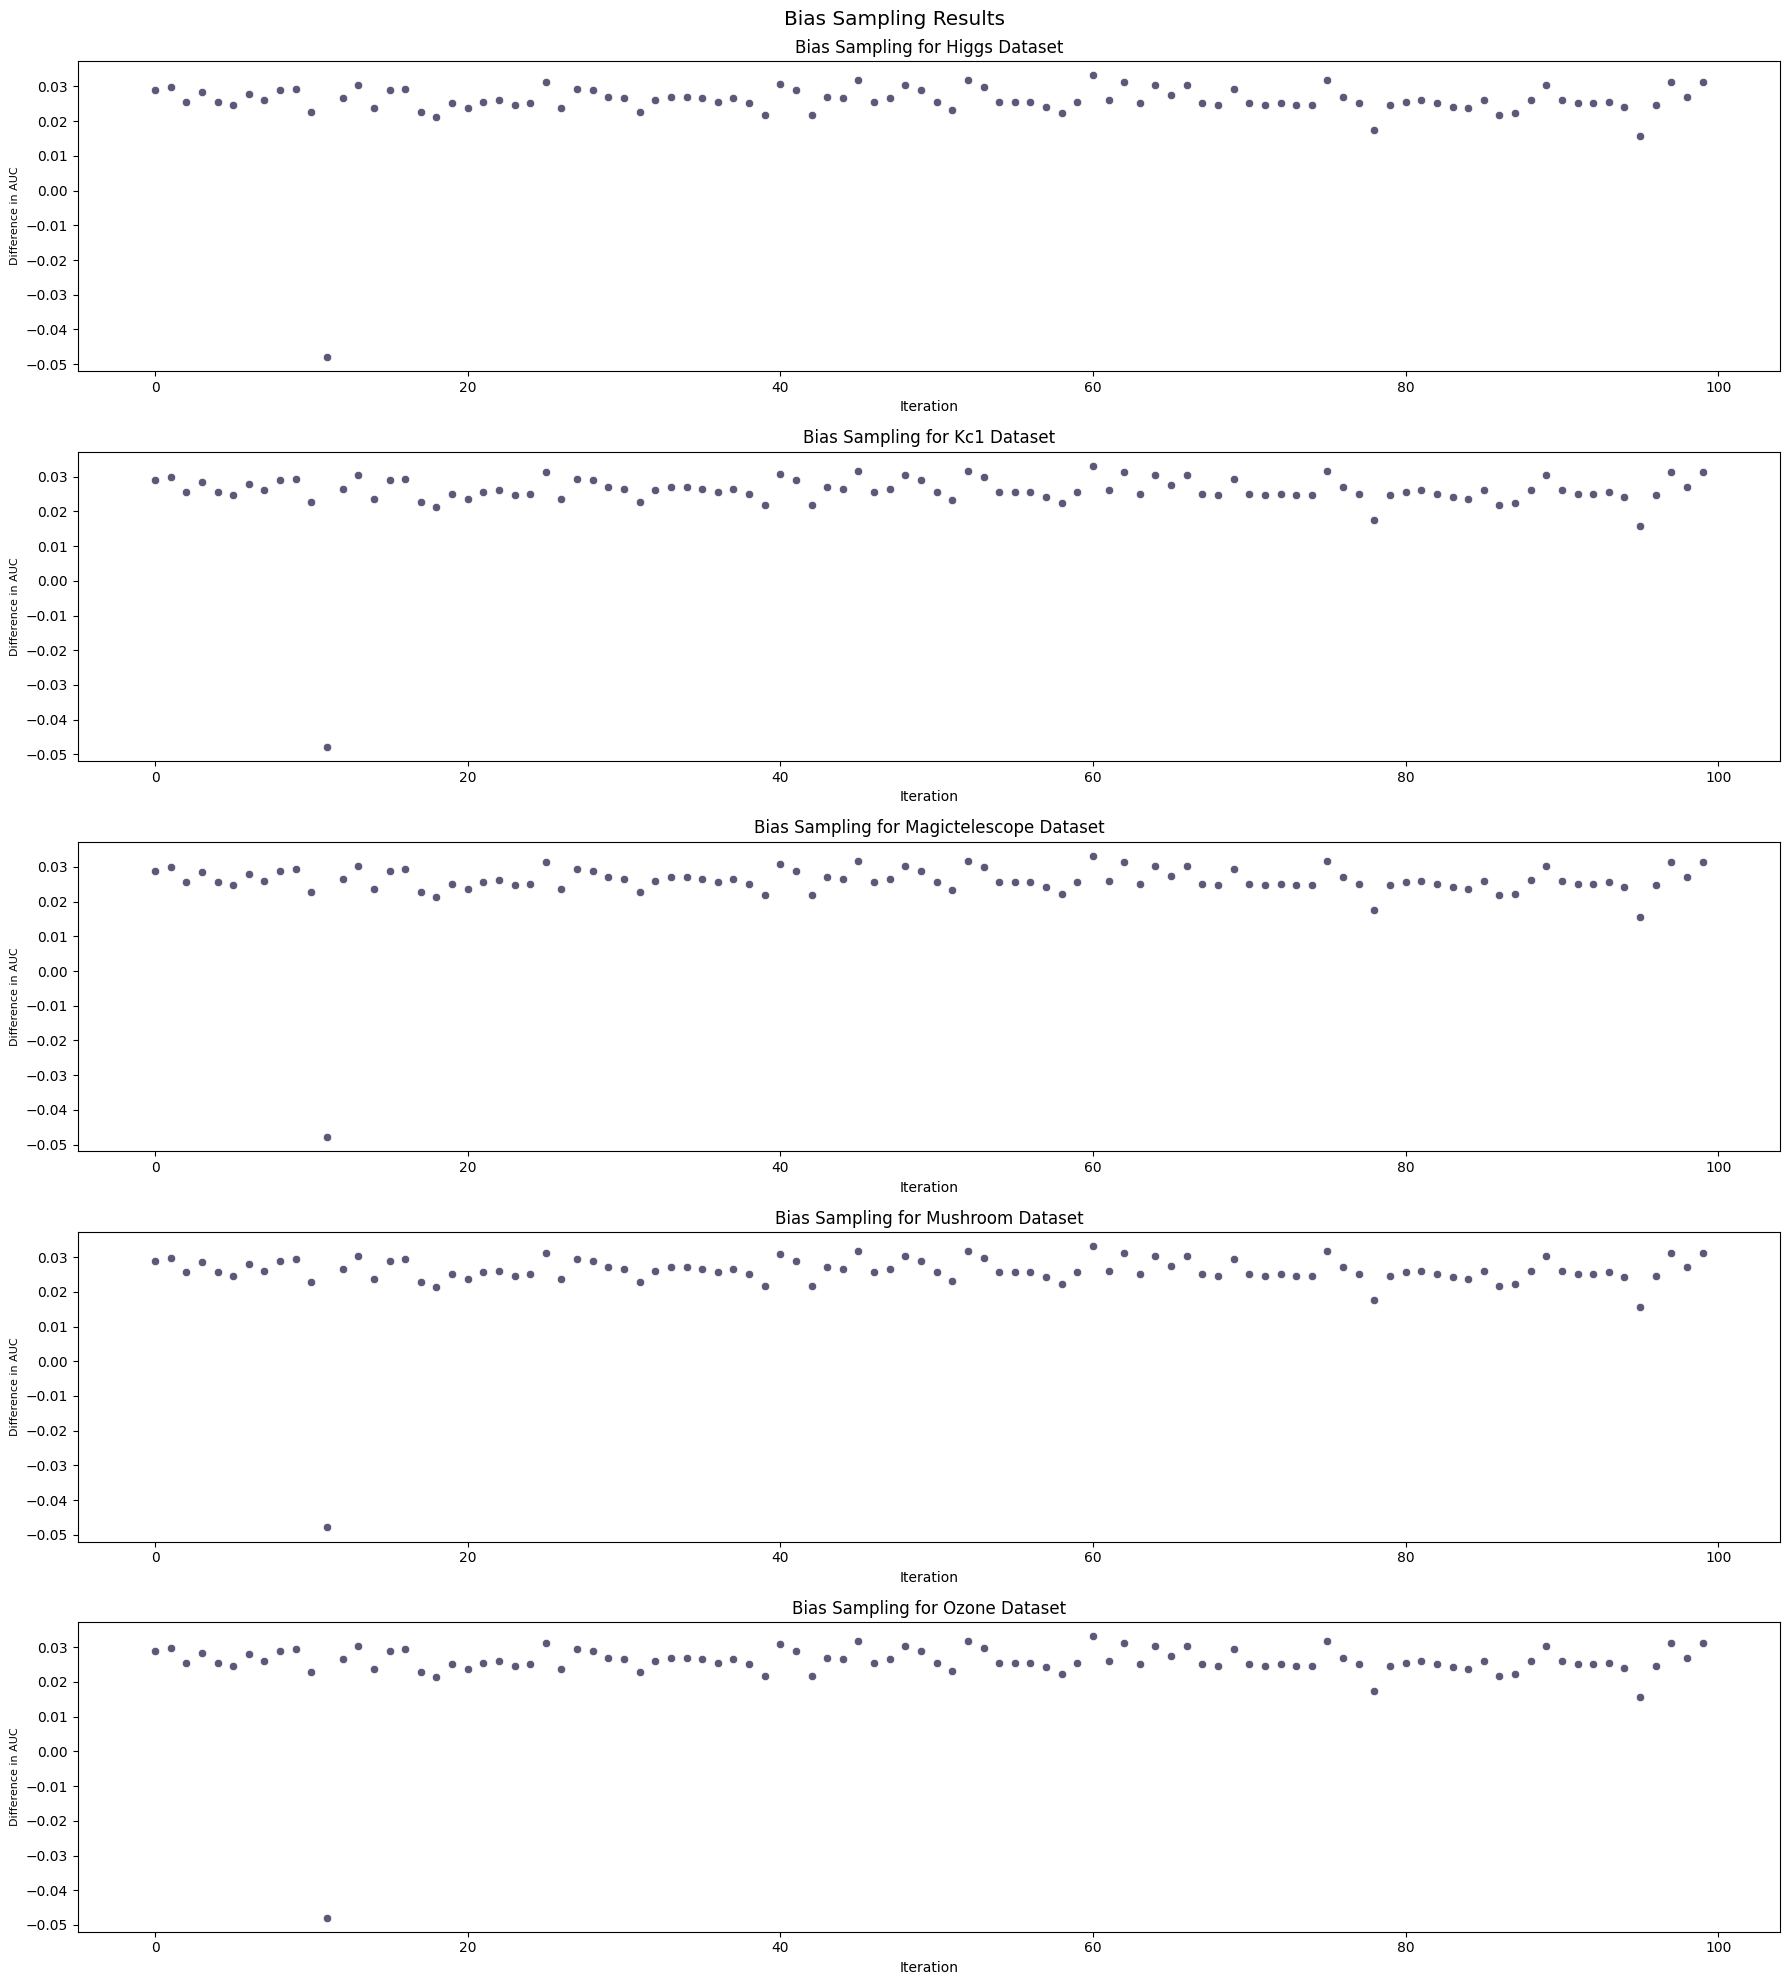

In [24]:
bias_sampling_plots(DATASETS, 'logreg', '#605678')

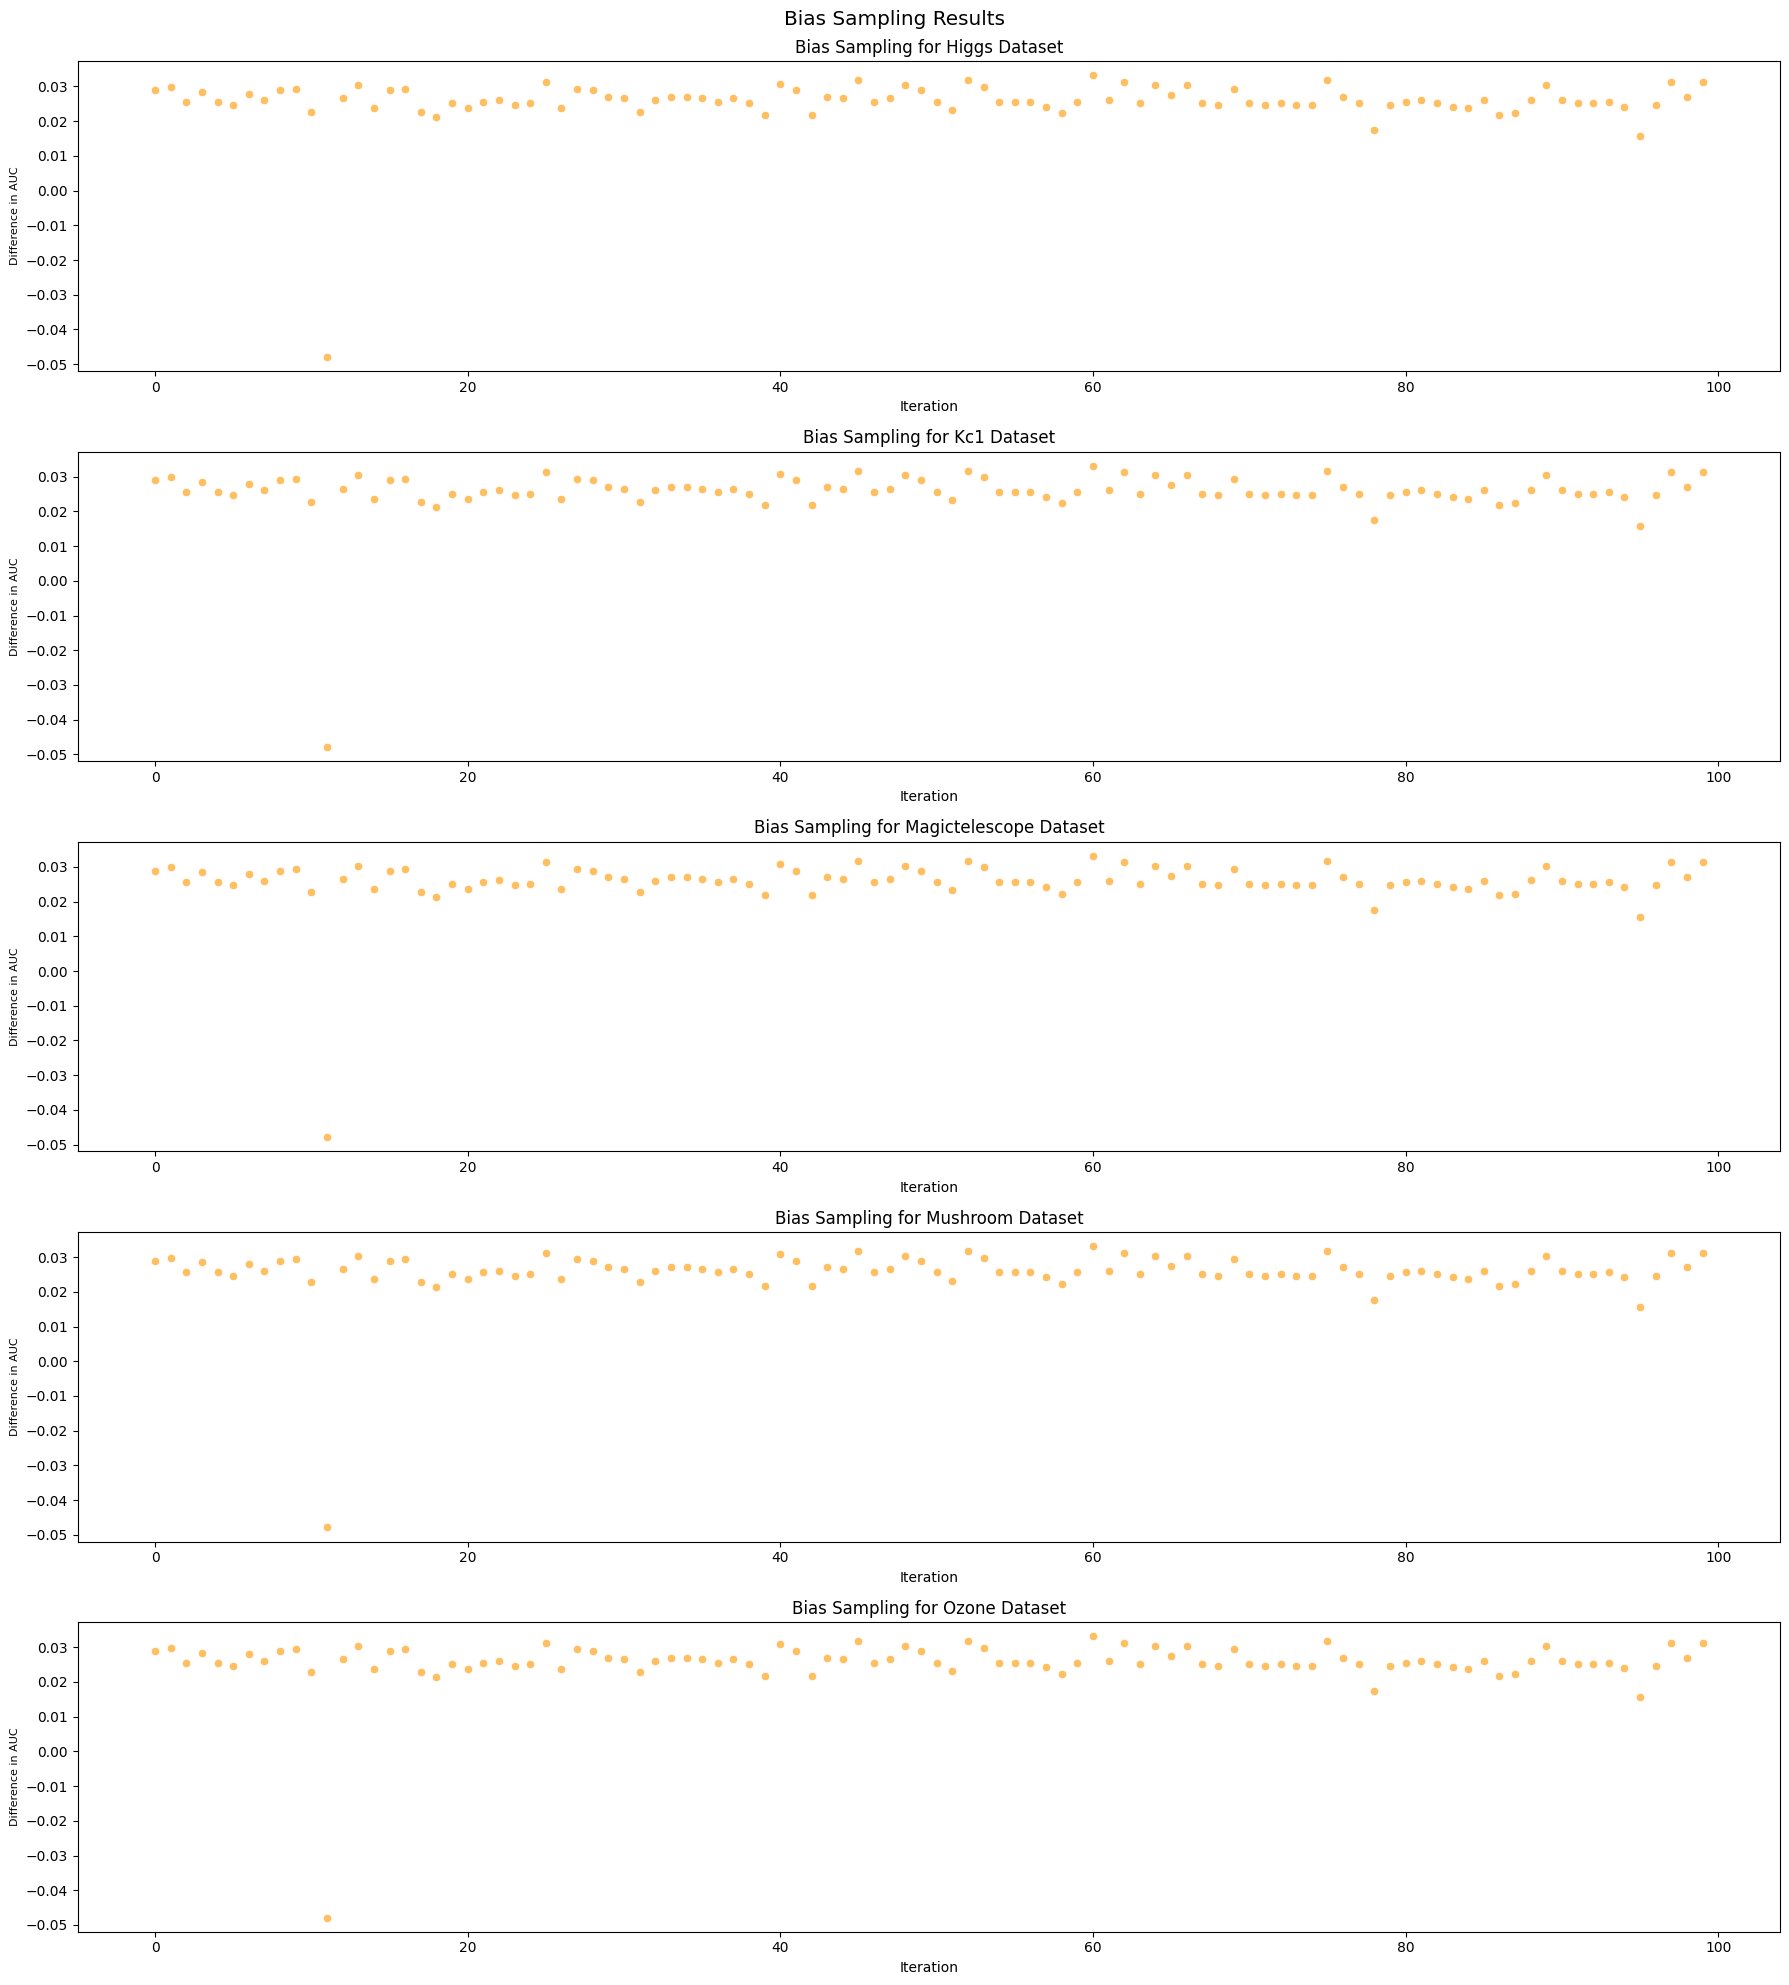

In [25]:
bias_sampling_plots(DATASETS, 'xgb', '#FFBF61')